In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt

from utils import read_air_passengers_csv, train_val_test_split

YEAR_CUTOFFS = [1953, 1958, 1960]

# (1) Data

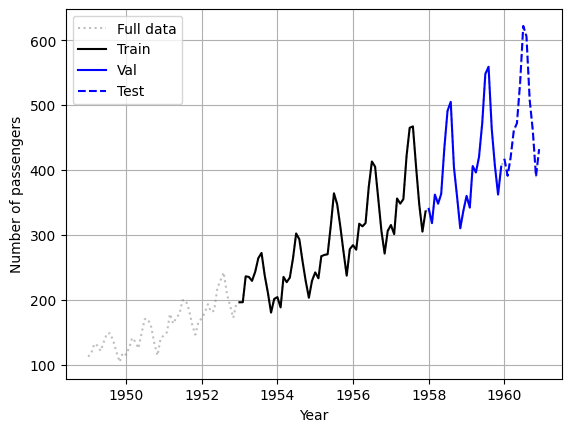

In [10]:
df = read_air_passengers_csv()
df_train, df_val, df_test = train_val_test_split(df, YEAR_CUTOFFS)

plt.xlabel("Year")
plt.ylabel("Number of passengers")

plt.plot(df, color="gray", alpha=0.5, linestyle="dotted", label="Full data")
plt.plot(df_train, color="k", label="Train")
plt.plot(df_val, color="b", label="Val")
plt.plot(df_test, color="b", linestyle="dashed", label="Test")

plt.grid()
plt.legend()
plt.show()

# (2) Exponential Smoothing

## (2.1) Simple Exponential Smoothing (SES)

Similar to the rolling averages, the exponential smoothing consists of a weighted rolling average, where the weights for previous values decrease exponentially the farther they are. Indeed, the formulae that describe the exponential smoothing method are
$$
\begin{align*}
s_0 &= y_0 \\
s_t &= \alpha y_t + (1 - \alpha) s_{t-1}
\end{align*}
$$
where $\alpha \in (0, 1)$ is the smoothing parameter. Notice how $s_t$ is related to $y_{t-m}$ by a factor of $(1 - \alpha)^m$ for all $m \in [0, t]$.

This algorithm can be easily implemented in Python like so :

In [11]:
def get_exponential_smoothing(y: np.array, alpha: float) -> np.array:
    """Compute exponential smoothing from scratch.

    Keywork arguments :
    y -- time-series data
    alpha -- smoothing parameter
    """
    if not len(y) > 0:
        raise Exception("Your np.array should have length >= 1.")
    if alpha <= 0 or alpha >= 1:
        raise Exception("Your smoothing parameter should be in (0, 1).")
    s = np.zeros(len(y))
    s[0] = y[0]
    for i in range(1, len(y)):
        s[i] = alpha * y[i] + (1 - alpha) * s[i - 1]
    return s

Luckily, there is already an object in the `statsmodels.tsa` package for Time-Series Analysis that contains this function for us. Below is a comparison of both methods :

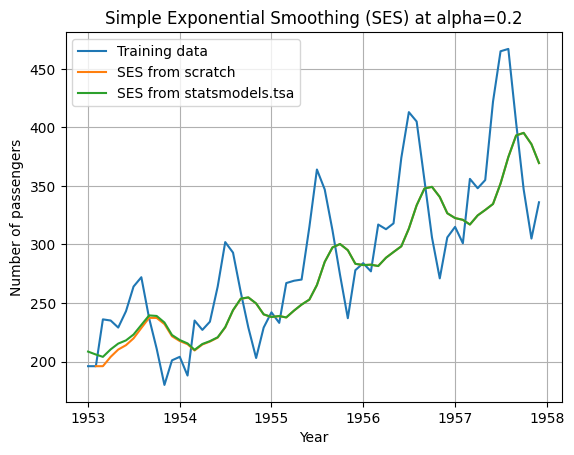

In [12]:
alpha = 0.2

ses_1_fitted = get_exponential_smoothing(y=df_train.values, alpha=alpha)

ses_2 = SimpleExpSmoothing(endog=df_train.values, initialization_method="heuristic")
ses_2 = ses_2.fit(smoothing_level=alpha, optimized=False)
ses_2_fitted = ses_2.fittedvalues

plt.title(f"Simple Exponential Smoothing (SES) at alpha={alpha}")
plt.xlabel("Year")
plt.ylabel("Number of passengers")
plt.plot(df_train, label="Training data")
plt.plot(df_train.index[1:], ses_1_fitted[:-1], label="SES from scratch")
plt.plot(df_train.index, ses_2_fitted, label="SES from statsmodels.tsa")
plt.grid()
plt.legend()
plt.show()

For some reason, the algorithm from `statsmodels.tsa` differs from my from-scratch function in the first fitted values. However, the last 17 values are practically equal, with differences lower than $10^{-3}$ :

In [13]:
n_check = 20
np.abs(ses_1_fitted[-n_check - 1 : -1] - ses_2_fitted[-n_check:]) < 1e-3

array([False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

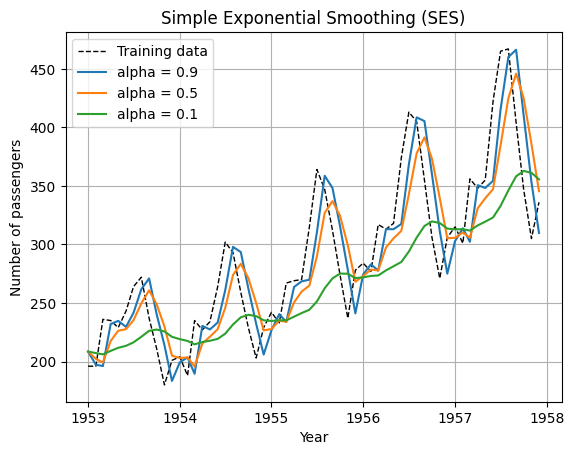

In [14]:
list_alphas = [0.9, 0.5, 0.1]

plt.title(f"Simple Exponential Smoothing (SES)")
plt.xlabel("Year")
plt.ylabel("Number of passengers")
plt.plot(df_train, c="k", ls="dashed", lw=1, label="Training data")

for alpha in list_alphas:
    ses = SimpleExpSmoothing(endog=df_train.values, initialization_method="heuristic")
    ses = ses.fit(smoothing_level=alpha, optimized=False)
    ses_fitted = ses.fittedvalues
    plt.plot(df_train.index, ses_fitted, label=f"alpha = {alpha}")

plt.grid()
plt.legend()
plt.show()

As expected from its definition in the formulas above, the lower the value of $\alpha$, the lower the weight for the closest previous $y_t$ value, which means that the smoothing effect is stronger. On the other hand, the higher the value of $\alpha$, the higher the weight given to $y_t$ and the lower the weight given to previous smoothing values $s_{t-1}$, which explains why the blue and orange lines are so close to the values of the training data. Indeed, they are practically shifted versions of the training data, replicating the seasonal effects.

With such data with strong seasonal effects, a low value of $\alpha$ seems to be the optimal choice.

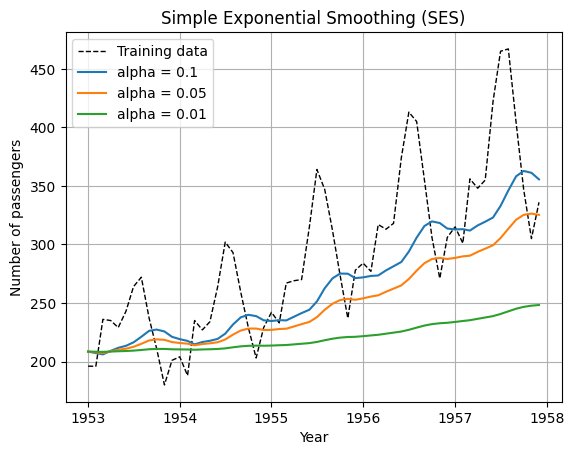

In [15]:
list_alphas = [0.1, 0.05, 0.01]

plt.title(f"Simple Exponential Smoothing (SES)")
plt.xlabel("Year")
plt.ylabel("Number of passengers")
plt.plot(df_train, c="k", ls="dashed", lw=1, label="Training data")

for alpha in list_alphas:
    ses = SimpleExpSmoothing(endog=df_train.values, initialization_method="heuristic")
    ses = ses.fit(smoothing_level=alpha, optimized=False)
    ses_fitted = ses.fittedvalues
    plt.plot(df_train.index, ses_fitted, label=f"alpha = {alpha}")

plt.grid()
plt.legend()
plt.show()

But of course, an extremely weak $\alpha$ means that the weight given to the closest previous $y_t$ value is so low that what we're left with is just a flat forecast. Indeed, the green line in the plot above is an extension of our first value in the training data $y_0$, with a small effect of other values $y_t$, as the weight $\alpha$ is too small to make them relevant.

Apparently, $\alpha = 0.1$ appears to be a sensible choice.

## (2.2) Automatic fit of $\alpha$

Indeed, the object `SimpleExpSmoothing` allows for an estimation approach where the smoothing parameter $\alpha$ is optimised. Below, both methods are compared. Although the automatic method finds a better fit for training data, the manual approach is more conservative with training data, but produces a more accurate forecast, with lower MAE and RMSE.

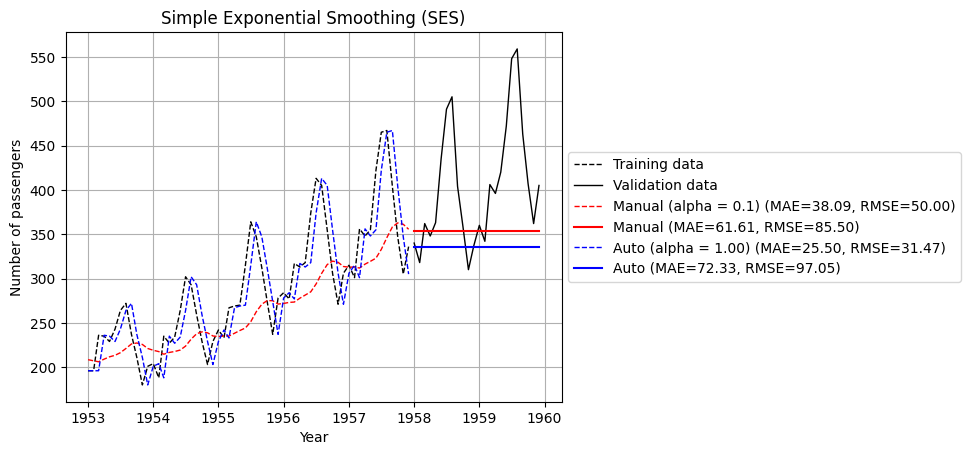

In [19]:
n_val = len(df_val)

ses_manual_alpha = 0.1
ses_manual = SimpleExpSmoothing(
    endog=df_train.values, initialization_method="heuristic"
)
ses_manual = ses_manual.fit(smoothing_level=ses_manual_alpha, optimized=False)
ses_manual_fitted = ses_manual.fittedvalues
ses_manual_fitted_mae = mean_absolute_error(df_train, ses_manual_fitted)
ses_manual_fitted_rmse = np.sqrt(mean_squared_error(df_train, ses_manual_fitted))

ses_manual_forecast = ses_manual.forecast(n_val)
ses_manual_forecast_mae = mean_absolute_error(df_val, ses_manual_forecast)
ses_manual_forecast_rmse = np.sqrt(mean_squared_error(df_val, ses_manual_forecast))

ses_auto = SimpleExpSmoothing(endog=df_train.values, initialization_method="estimated")
ses_auto = ses_auto.fit()
ses_auto_alpha = ses_auto.model.params["smoothing_level"]
ses_auto_fitted = ses_auto.fittedvalues
ses_auto_fitted_mae = mean_absolute_error(df_train, ses_auto_fitted)
ses_auto_fitted_rmse = np.sqrt(mean_squared_error(df_train, ses_auto_fitted))

ses_auto_forecast = ses_auto.forecast(n_val)
ses_auto_mae = mean_absolute_error(df_val, ses_auto_forecast)
ses_auto_rmse = np.sqrt(mean_squared_error(df_val, ses_auto_forecast))

plt.title(f"Simple Exponential Smoothing (SES)")
plt.xlabel("Year")
plt.ylabel("Number of passengers")
plt.plot(df_train, c="k", lw=1, ls="dashed", label="Training data")
plt.plot(df_val, c="k", lw=1, label="Validation data")

plt.plot(
    df_train.index,
    ses_manual_fitted,
    c="r",
    lw=1,
    ls="dashed",
    label=f"Manual (alpha = {ses_manual_alpha}) (MAE={ses_manual_fitted_mae:.2f}, RMSE={ses_manual_fitted_rmse:.2f})",
)
plt.plot(
    df_val.index,
    ses_manual_forecast,
    c="r",
    label=f"Manual (MAE={ses_manual_forecast_mae:.2f}, RMSE={ses_manual_forecast_rmse:.2f})",
)

plt.plot(
    df_train.index,
    ses_auto_fitted,
    c="b",
    lw=1,
    ls="dashed",
    label=f"Auto (alpha = {ses_auto_alpha:.2f}) (MAE={ses_auto_fitted_mae:.2f}, RMSE={ses_auto_fitted_rmse:.2f})",
)
plt.plot(
    df_val.index,
    ses_auto_forecast,
    c="b",
    label=f"Auto (MAE={ses_auto_mae:.2f}, RMSE={ses_auto_rmse:.2f})",
)

plt.grid()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

## (2.3) Other methods

There are plenty of other methods based on Exponential Smoothing. Below, I compare two simple implementations of the Holt's and the Holt-Winters' methods. I observe how the Holt's method takes into account the trend of the data and extends it for the forecast, and the Holt-Winters' method incorporates seasonal effects. For this reason, this model is the most preferred for this dataset.

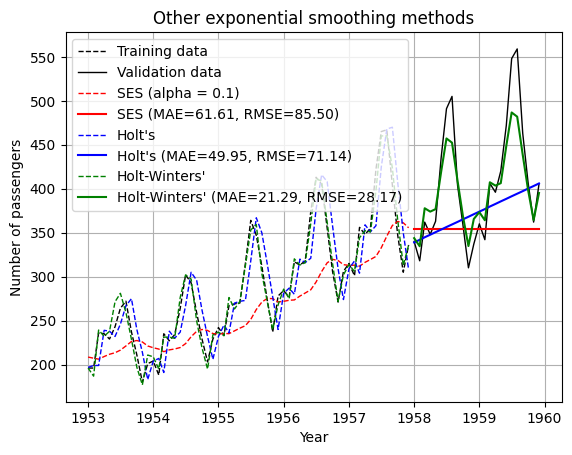

In [21]:
n_val = len(df_val)

ses_alpha = 0.1
ses = SimpleExpSmoothing(endog=df_train.values, initialization_method="heuristic")
ses = ses.fit(smoothing_level=ses_alpha, optimized=False)
ses_fitted = ses.fittedvalues
ses_forecast = ses.forecast(n_val)
ses_mae = mean_absolute_error(df_val, ses_forecast)
ses_rmse = np.sqrt(mean_squared_error(df_val, ses_forecast))

holt = Holt(endog=df_train.values, initialization_method="estimated")
holt = holt.fit()
holt_fitted = holt.fittedvalues
holt_forecast = holt.forecast(n_val)
holt_mae = mean_absolute_error(df_val, holt_forecast)
holt_rmse = np.sqrt(mean_squared_error(df_val, holt_forecast))

holt_winters = ExponentialSmoothing(
    endog=df_train.values, trend="add", seasonal="add", seasonal_periods=12
)
holt_winters = holt_winters.fit()
holt_winters_fitted = holt_winters.fittedvalues
holt_winters_forecast = holt_winters.forecast(n_val)
holt_winters_mae = mean_absolute_error(df_val, holt_winters_forecast)
holt_winters_rmse = np.sqrt(mean_squared_error(df_val, holt_winters_forecast))

plt.title(f"Other exponential smoothing methods")
plt.xlabel("Year")
plt.ylabel("Number of passengers")
plt.plot(df_train, c="k", lw=1, ls="dashed", label="Training data")
plt.plot(df_val, c="k", lw=1, label="Validation data")

plt.plot(
    df_train.index,
    ses_fitted,
    c="r",
    lw=1,
    ls="dashed",
    label=f"SES (alpha = {ses_alpha})",
)
plt.plot(
    df_val.index,
    ses_forecast,
    c="r",
    label=f"SES (MAE={ses_mae:.2f}, RMSE={ses_rmse:.2f})",
)

plt.plot(df_train.index, holt_fitted, c="b", lw=1, ls="dashed", label=f"Holt's")
plt.plot(
    df_val.index,
    holt_forecast,
    c="b",
    label=f"Holt's (MAE={holt_mae:.2f}, RMSE={holt_rmse:.2f})",
)

plt.plot(
    df_train.index,
    holt_winters_fitted,
    c="g",
    lw=1,
    ls="dashed",
    label=f"Holt-Winters'",
)
plt.plot(
    df_val.index,
    holt_winters_forecast,
    c="g",
    label=f"Holt-Winters' (MAE={holt_winters_mae:.2f}, RMSE={holt_winters_rmse:.2f})",
)

plt.grid()
plt.legend()
plt.show()